In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from tensorflow import data, nn, expand_dims
from tensorflow.keras import layers, utils
from tensorflow.keras.models import Sequential

In [29]:
data_dir = pathlib.Path("cats_and_dogs").with_suffix('')

In [30]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3499


In [31]:
batch_size = 32
img_height = 180
img_width = 180

In [32]:
train_ds = utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3499 files belonging to 2 classes.
Using 2800 files for training.


In [33]:
val_ds = utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3499 files belonging to 2 classes.
Using 699 files for validation.


In [34]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


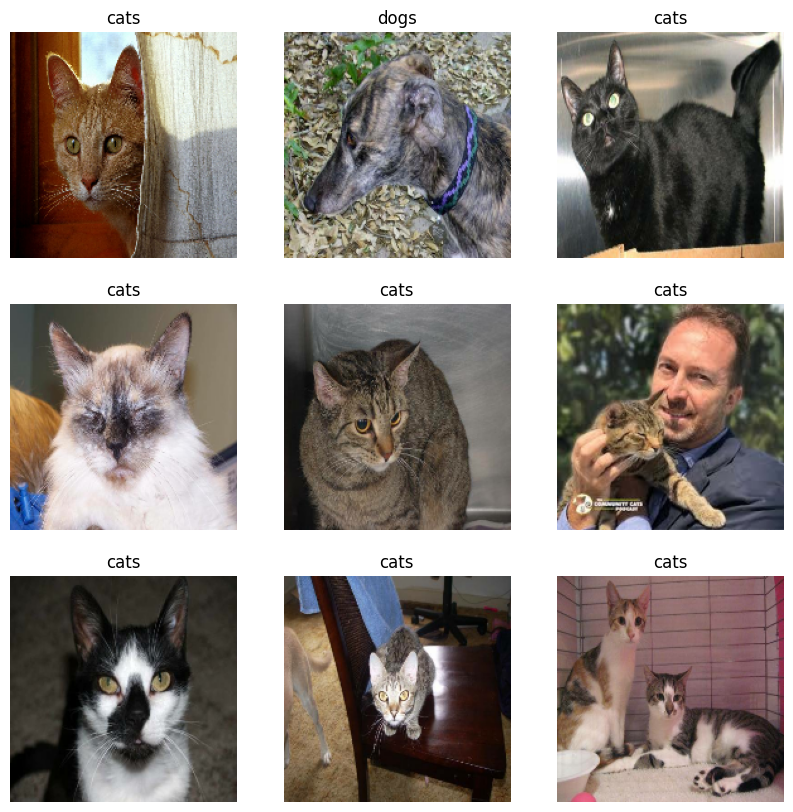

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
normalization_layer = layers.Rescaling(1./255)

In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [40]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


88/88 [==============================] - 36s 389ms/step - loss: 0.6992 - accuracy: 0.5554 - val_loss: 0.6763 - val_accuracy: 0.5436
Epoch 2/10
88/88 [==============================] - 33s 371ms/step - loss: 0.6327 - accuracy: 0.6446 - val_loss: 0.6223 - val_accuracy: 0.6524
Epoch 3/10
88/88 [==============================] - 33s 373ms/step - loss: 0.5486 - accuracy: 0.7236 - val_loss: 0.6122 - val_accuracy: 0.6824
Epoch 4/10
88/88 [==============================] - 33s 374ms/step - loss: 0.4493 - accuracy: 0.7964 - val_loss: 0.6234 - val_accuracy: 0.6824
Epoch 5/10
88/88 [==============================] - 33s 379ms/step - loss: 0.3509 - accuracy: 0.8482 - val_loss: 0.6901 - val_accuracy: 0.6509
Epoch 6/10
88/88 [==============================] - 33s 373ms/step - loss: 0.2439 - accuracy: 0.8975 - val_loss: 0.8280 - val_accuracy: 0.6967
Epoch 7/10
88/88 [==============================] - 34s 389ms/step - loss: 0.1433 - accuracy: 0.9479 - val_loss: 1.1180 - val_accuracy: 0.6781
Epoch 8/10

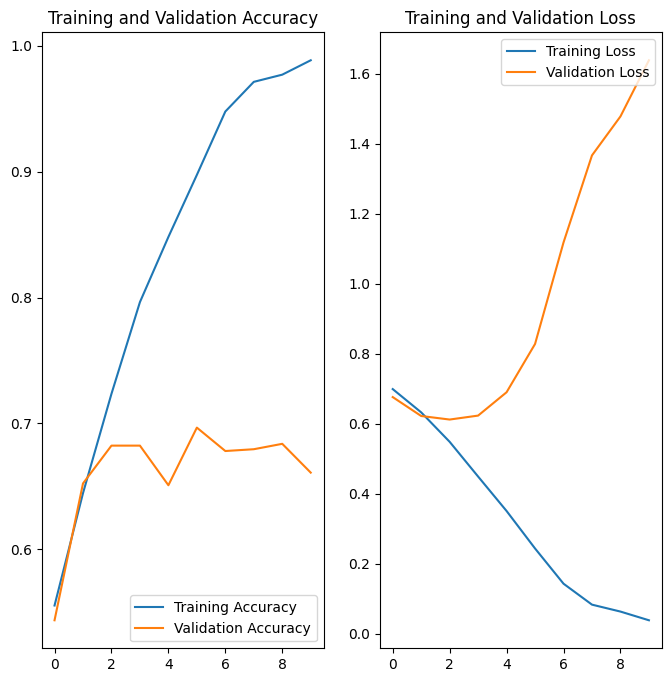

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

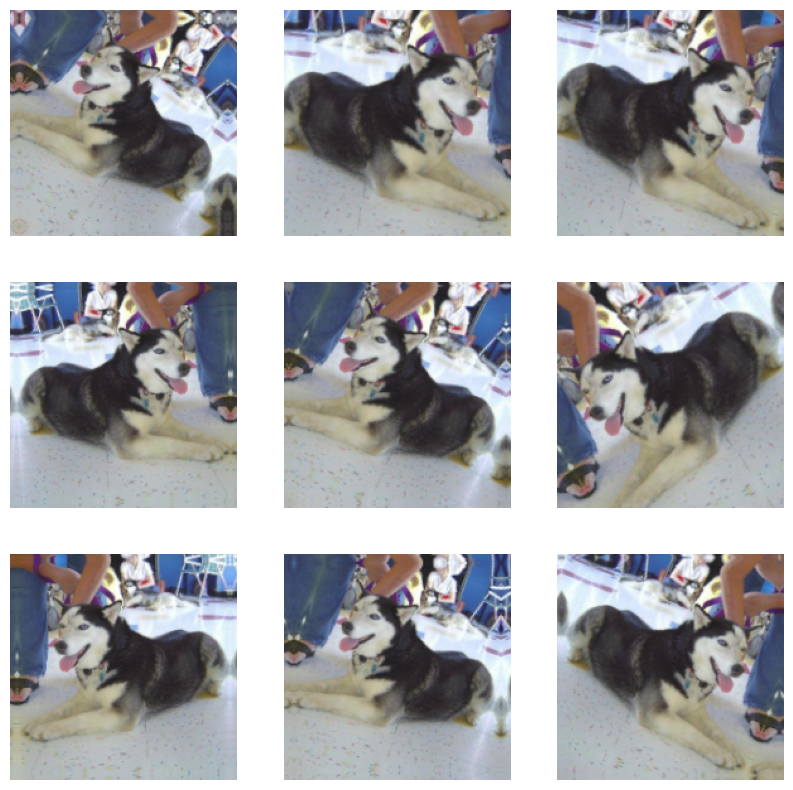

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [47]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [50]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


88/88 [==============================] - 57s 584ms/step - loss: 0.7490 - accuracy: 0.5225 - val_loss: 0.6878 - val_accuracy: 0.5851
Epoch 2/15
88/88 [==============================] - 50s 563ms/step - loss: 0.6812 - accuracy: 0.5854 - val_loss: 0.6785 - val_accuracy: 0.5479
Epoch 3/15
88/88 [==============================] - 44s 505ms/step - loss: 0.6498 - accuracy: 0.6218 - val_loss: 0.6356 - val_accuracy: 0.6767
Epoch 4/15
88/88 [==============================] - 46s 523ms/step - loss: 0.6142 - accuracy: 0.6707 - val_loss: 0.5951 - val_accuracy: 0.6910
Epoch 5/15
88/88 [==============================] - 46s 518ms/step - loss: 0.5886 - accuracy: 0.6914 - val_loss: 0.5805 - val_accuracy: 0.6981
Epoch 6/15
88/88 [==============================] - 45s 509ms/step - loss: 0.5759 - accuracy: 0.7046 - val_loss: 0.5598 - val_accuracy: 0.7096
Epoch 7/15
88/88 [==============================] - 45s 514ms/step - loss: 0.5674 - accuracy: 0.7143 - val_loss: 0.5718 - val_accuracy: 0.6838
Epoch 8/15

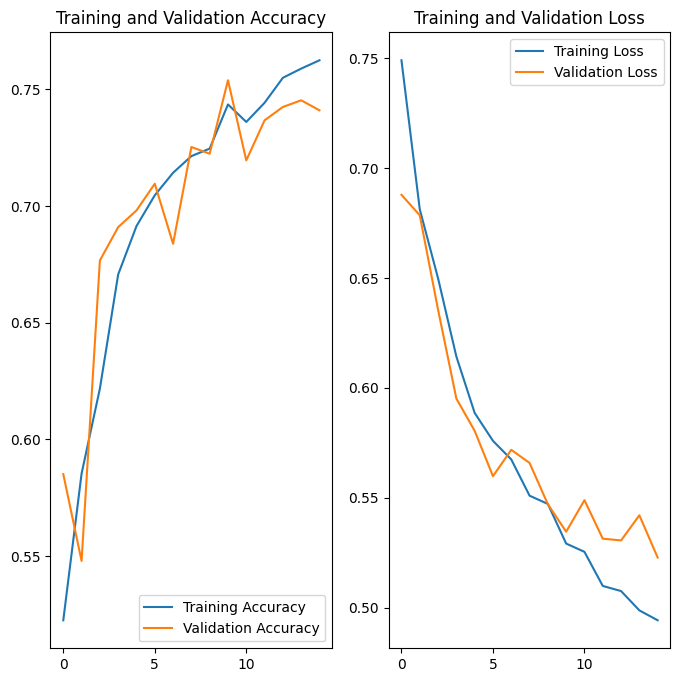

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
cat_path = "C:\\Users\\andre\\OneDrive\\Desktop\\download.jpg"
img = utils.load_img(cat_path, target_size=(img_height, img_width))

img_array = utils.img_to_array(img)
img_array = expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 140ms/step
This image most likely belongs to cats with a 56.88 percent confidence.


In [53]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
